In [1]:
import os
import sys
import time
import errno

import numpy as np
import scipy as scp
import pandas as pd
import seaborn as sns

In [2]:
import numba
from numba import jit

In [3]:
import torch
import sbi
import sbi.inference
from sbi.inference import SNPE, prepare_for_sbi ,simulate_for_sbi
from sbi.inference.base import infer
from sbi.analysis import ActiveSubspace, pairplot
import sbi.utils as utils

In [4]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [5]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

In [6]:
%pylab inline
#%matplotlib notebook

plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/meysam/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['cast']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/tmp/ipykernel_451259/94587667.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk');


In [7]:
print(f"Numpy version: {np.__version__}")
print(f"Numba version: {numba.__version__}")
print(f"Matplotlib` version: {matplotlib.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"SciPy version: {scp.__version__}")
print(f"SBI version: {sbi.__version__}")

Numpy version: 1.24.4
Numba version: 0.57.1
Matplotlib` version: 3.7.1
Pandas version: 2.0.2
SciPy version: 1.10.1
SBI version: 0.21.0


In [8]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/SBI/MPR_NMM_SBI'

In [9]:
Res_dir='Res_SBI_NMM_MPR_SDE_Istep_RVfeatures_sumstatspeaks_100ksims_v21'

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [11]:
def Montbrio_SDEmodel(params, constants, I_input, dt, ts):
   
    #parameters
    delta, eta, J, sigma  = params[0], params[1], params[2], params[3]

    dt = float(dt) #Euler inetgration

    # simulation from initial point
    v = np.zeros_like(ts)  # membrane potential
    r = np.zeros_like(ts)  # firing rate

    # fixed parameters (initial conditions)
    v_init, r_init=constants[0], constants[1]
    v[0],r[0]= v_init, r_init

    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))
     

In [12]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

In [13]:
delta=0.7
eta=-4.6
J=14.5
sigma=0.1

In [14]:
eta/delta, J/np.sqrt(delta)

(-6.571428571428571, 17.330814835348708)

In [15]:
params=[delta, eta, J, sigma]

In [16]:
t_init = 0.0
t_final = 100.0

dt = 0.001
ts = np.arange(t_init,t_final,dt)

nt=ts.shape[0]

In [17]:
nIsteps = int((t_final - t_init)/dt)
nIsteps

100000

In [18]:
I0=3.
t_on=30.
t_off=60.

In [19]:
I_input=[]
I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]

In [20]:
I_input =np.asarray(I_input)

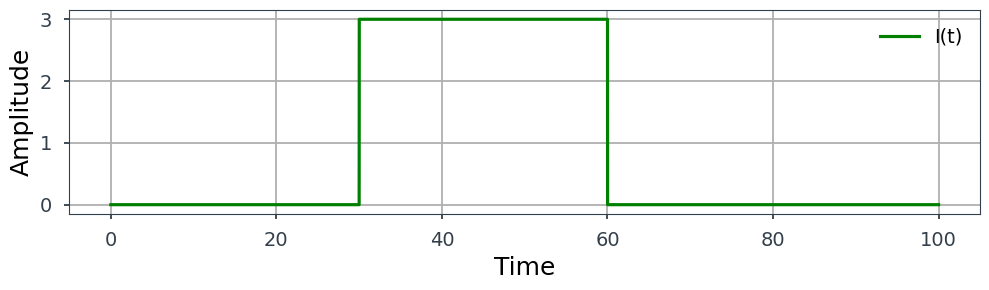

In [21]:
plt.figure(figsize=(10, 3))
plt.plot(ts, I_input,color='g' , label='I(t)')
plt.xlabel('Time', fontsize=18); 
plt.ylabel('Amplitude', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
v0 = -3.0
r0 = 0.5

In [23]:
constants=[v0, r0]

In [24]:
start_time = time.time()

rv = Montbrio_SDEmodel(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.5769217014312744 seconds ---


In [25]:
## first run using JIT numba takes time due to compilation, but then in is in fly!

In [26]:
start_time = time.time()

rv = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 1.771446704864502 seconds ---


In [27]:
start_time = time.time()

rv = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
--- 0.009644031524658203 seconds ---


In [28]:
v=rv[0:nt]
r=rv[nt:2*nt]

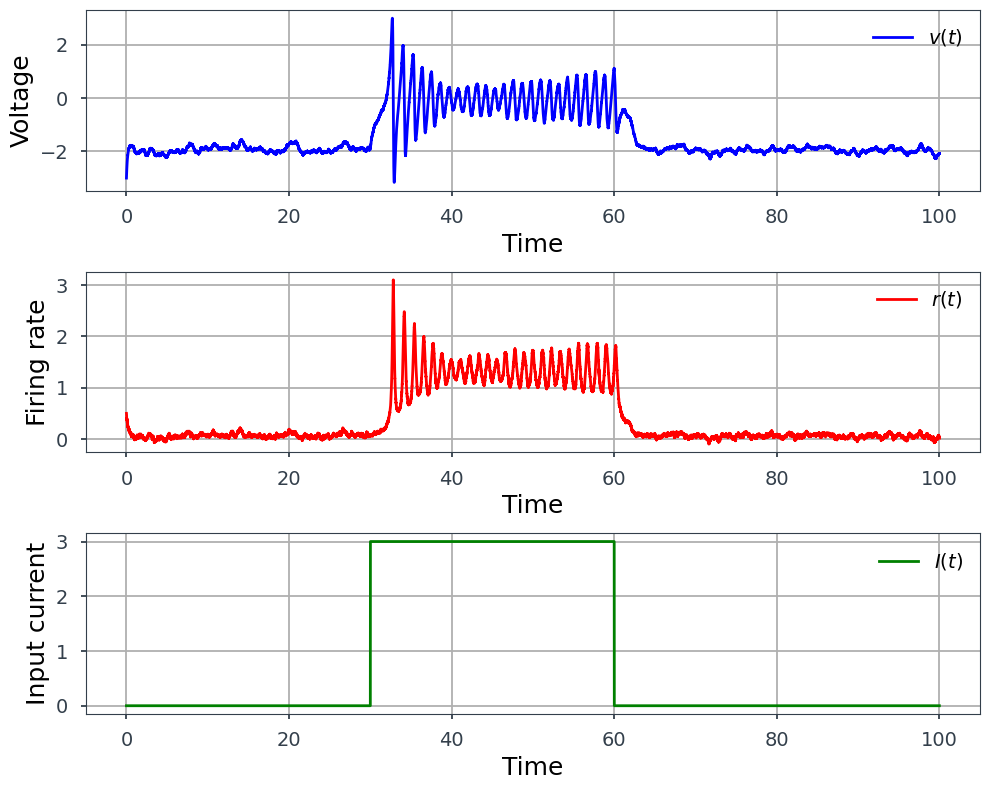

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(ts, v, 'b', linewidth=2, label='$v(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Voltage', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.subplot(312)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Firing rate', fontsize=18); 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(313)
plt.plot(ts, I_input, 'g', linewidth=2, label='$I(t)$')
plt.xlabel('Time', fontsize=18); plt.ylabel('Input current', fontsize=18); 
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_Istep.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_Istep.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_Istep.svg"), dpi=300)

plt.show()

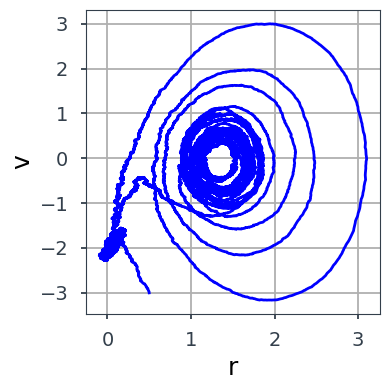

In [30]:
plt.figure(figsize=(4, 4))
plt.plot(r, v, 'b', linewidth=2)
plt.ylabel('v', fontsize=18); 
plt.xlabel('r', fontsize=18);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.grid()

# Features

In [31]:
from MPR_NMM_sumstats import calculate_summary_statistics

In [32]:
_=calculate_summary_statistics(v, dt, ts, t_on, t_off)

In [33]:
_

array([-1.92996349,  0.13168495, -1.93577028, -0.22371594,  3.51246687,
       -0.11380798,  0.73146596, -0.12675646,  0.07201353,  1.89079762,
       -1.86731216,  0.33788858, -1.93945519,  3.93518477, 18.99725857,
       25.        , 32.712     ])

## 1. Simulator


The wrapper takes only parameters as the input and return the features (summary statistics) or raw time series as the output, the later case if we like to save the simulations and then load them and calculate the corresponding features.

In [34]:
def Montbrio_SDEmodel_Wrapper(params):

    params = np.asarray(params)
    
    t_init = 0.0
    t_final = 100.0

    dt = 0.001
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]
    nIsteps = int((t_final - t_init)/dt)

    I0=3.
    t_on=30.
    t_off=60.

    I_input=[]
    I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    I_input =np.asarray(I_input)

    v0 = -3.0
    r0 = 0.5
    
    constants=[v0, r0]
    
    rv = Montbrio_SDEmodel_numba(params, constants, I_input, dt, ts)
    v=rv[0:nt]
    r=rv[nt:2*nt]
    
    summstats_r = torch.as_tensor(calculate_summary_statistics(r.reshape(-1), dt, ts, t_on, t_off))
    summstats_v = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), dt, ts, t_on, t_off))

    summstats= np.concatenate([summstats_v, summstats_r]).flatten()
    
    return summstats
  

In [35]:
delta_true=0.7
eta_true=-4.6
J_true=14.5
sigma=0.1

In [36]:
params_true=[delta_true, eta_true, J_true, sigma]
params_true

[0.7, -4.6, 14.5, 0.1]

In [37]:
Montbrio_SDEmodel_Wrapper(params_true).shape

(34,)

In [38]:
rv = Montbrio_SDEmodel_numba(params_true, constants, I_input,  dt, ts)
v=rv[0:nt]
r=rv[nt:2*nt]

In [39]:
ts.shape, v.shape, r.shape

((100000,), (100000,), (100000,))

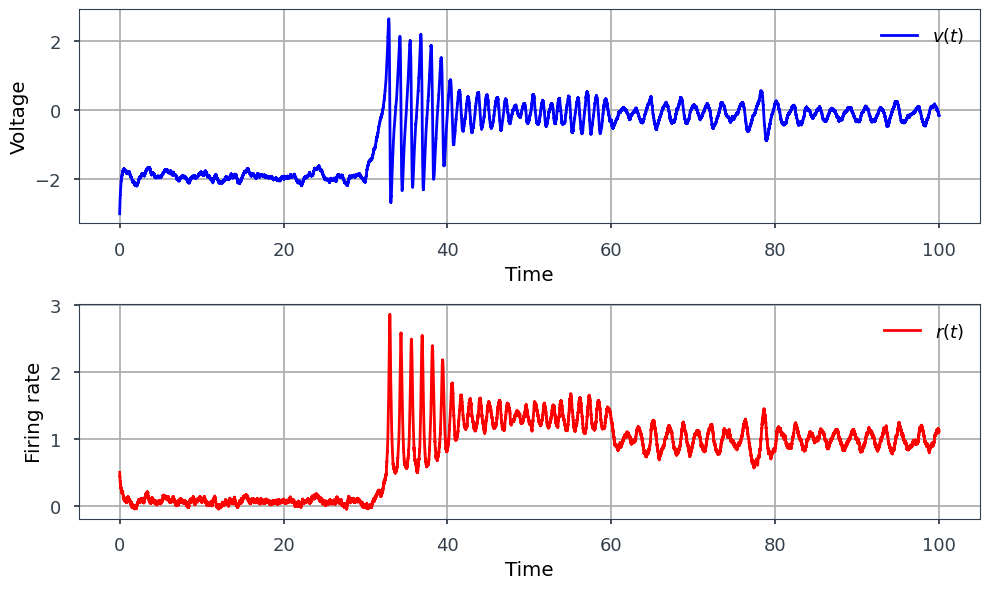

In [40]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v, 'b',  linewidth=2, label='$v(t)$')
plt.xlabel('Time'); plt.ylabel('Voltage'); 
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r, 'r', linewidth=2, label='$r(t)$')
plt.xlabel('Time'); plt.ylabel('Firing rate'); 
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.grid()
plt.show()

## 2. Prior over model parameters


In [41]:
prior_min = [0.1, -10., 5.0, 0.]
prior_max = [5.0, -3.0, 20., 1.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [42]:
prior.sample()

tensor([ 3.5435, -4.6005,  8.1277,  0.2858])

In [43]:
num_params=prior.sample().shape[0]
num_params

4

### 3. Inference

In [44]:
num_sims=100000

In [45]:
# 1-step simualtion, calculation of features, and inference

start_time = time.time()

posterior = infer(Montbrio_SDEmodel_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 141 epochs.------------------------------------------------------------
--- 5291.847986459732 seconds ---


### Observed Data

In [46]:
params_label=np.array(['delta', 'eta', 'J', 'sigma'])
params_label=np.array(['$\Delta$', '$\eta$', '$J$', '$\sigma$'])

In [47]:
delta_true=0.7
eta_true=-4.6
J_true=14.5
sigma_true=0.1

true_params = np.array([delta_true, eta_true, J_true, sigma_true])

In [48]:
x_obs= Montbrio_SDEmodel_numba(true_params, constants, I_input, dt, ts)
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics_v=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)
x_obs_summary_statistics_r=calculate_summary_statistics(r_obs.reshape(-1), dt, ts, t_on, t_off)
x_obs_summary_statistics=np.concatenate([x_obs_summary_statistics_v, x_obs_summary_statistics_r]).flatten()

In [49]:
x_obs_summary_statistics.shape

(34,)

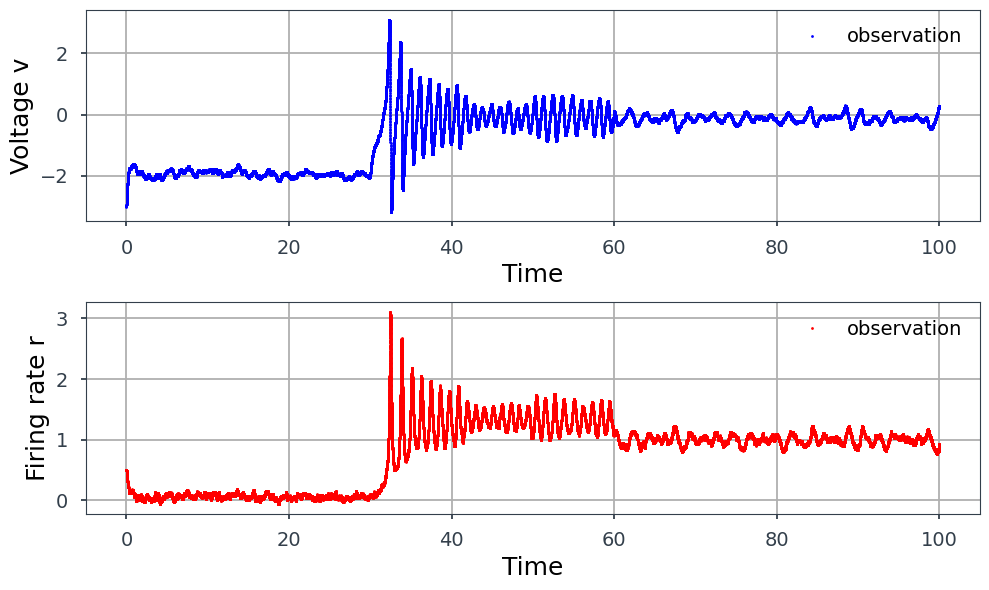

In [50]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsI.svg"), dpi=300)
plt.show()

### Posterior

In [51]:
num_samples=10000

In [52]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

posterior_samples.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 4)

In [53]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]
sigma_est=posterior_samples[:,3]

In [54]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())
print("sigma_est=", sigma_est.mean())

delta_est= 0.819371
eta_est= -4.552662
J_est= 14.364419
sigma_est= 0.094651386


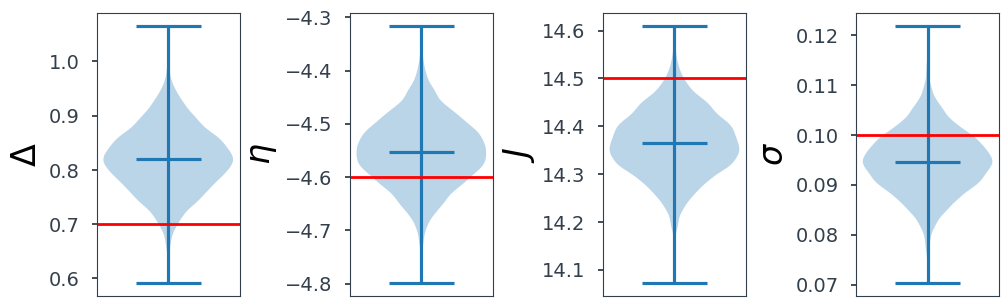

In [55]:
plt.figure(figsize=(10, 3))
for i, variables in enumerate([delta_est, eta_est, J_est, sigma_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obsI.svg"), dpi=300)
plt.show()

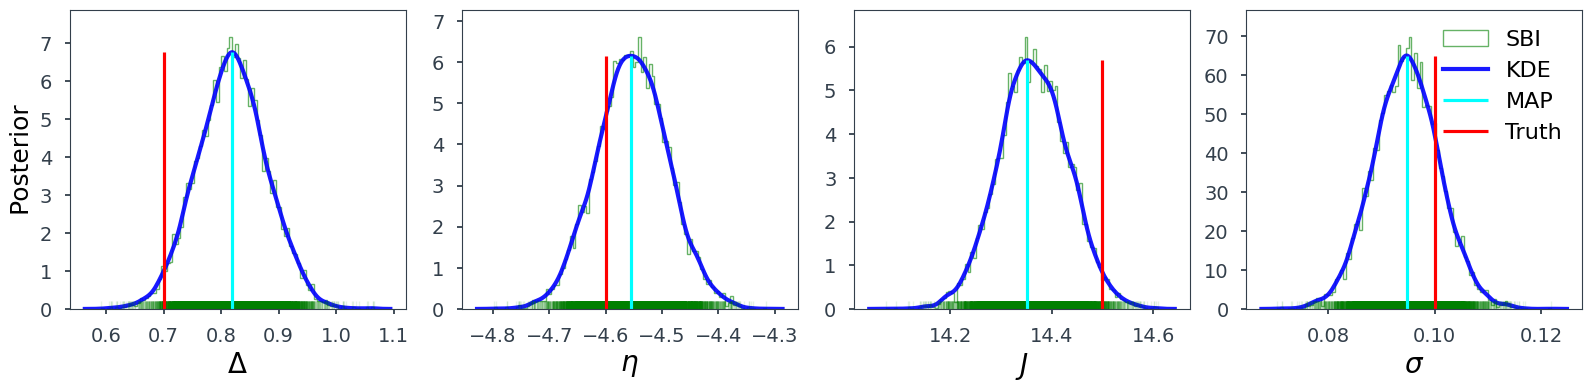

In [56]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 4, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==3:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsI.svg"), dpi=300)

plt.show()

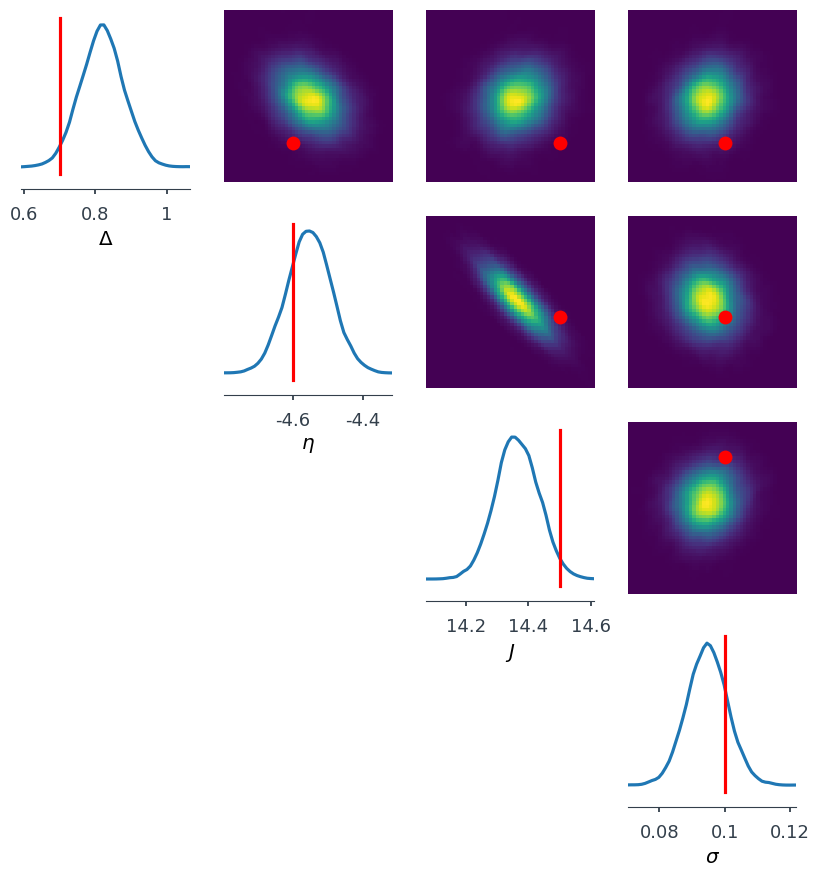

In [57]:
fig, axes = pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
            
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsI.svg"), dpi=300)
plt.show()

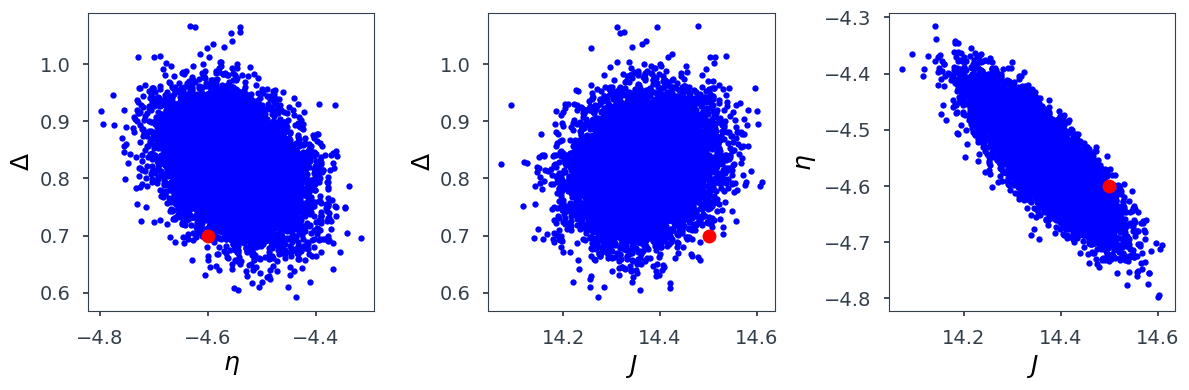

In [58]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(eta_est, delta_est,'.', color='blue')
plt.plot(eta_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$\eta$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(J_est, delta_est, '.',color='blue')
plt.plot(J_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(J_est, eta_est, '.', color='blue')
plt.plot(J_true, eta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\eta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsI.svg"), dpi=300)

plt.show()

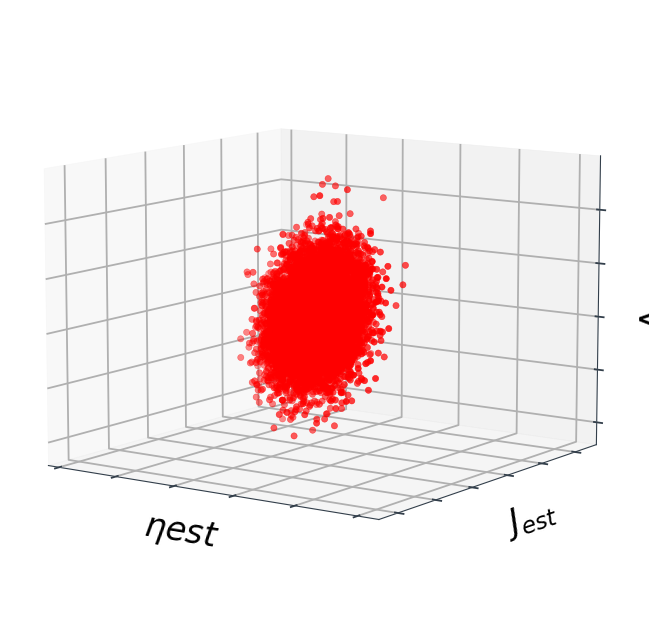

In [59]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =eta_est
y =J_est
z =delta_est
ax.scatter(x, y, z, c='red', marker='o')
ax.set_xlabel("$\eta{est}$", fontsize=24)
ax.set_ylabel("$J_{est}$", fontsize=24)
ax.set_zlabel("$\Delta_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, 125)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsI.svg"), dpi=300)
plt.show()

In [60]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

In [61]:
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)

df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

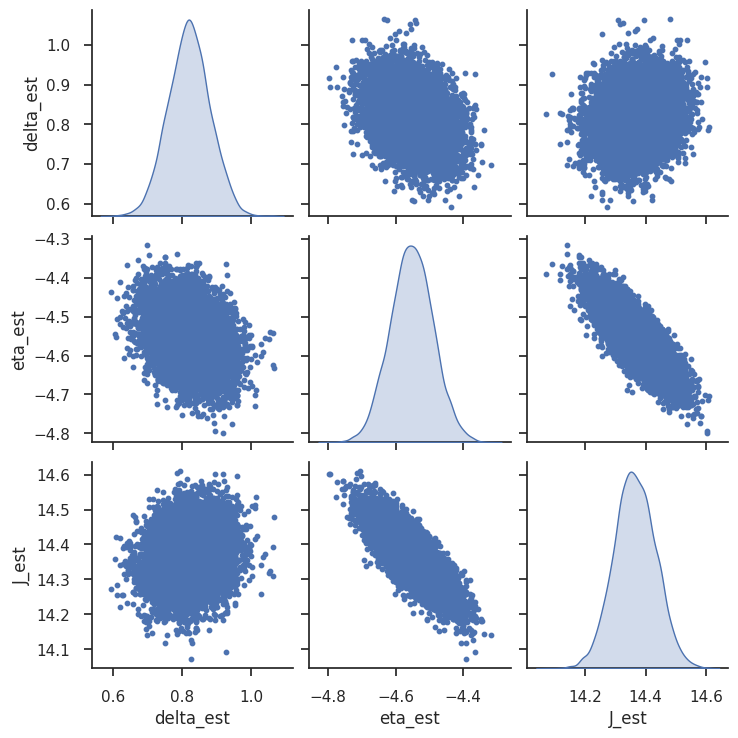

In [62]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
#g.set(xticklabels=[])
#g.set(yticklabels=[])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsI.svg"), dpi=300)
plt.show()

In [63]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,-0.323724,0.165633
eta_est,-0.323724,1.000000,-0.816003
J_est,0.165633,-0.816003,1.000000


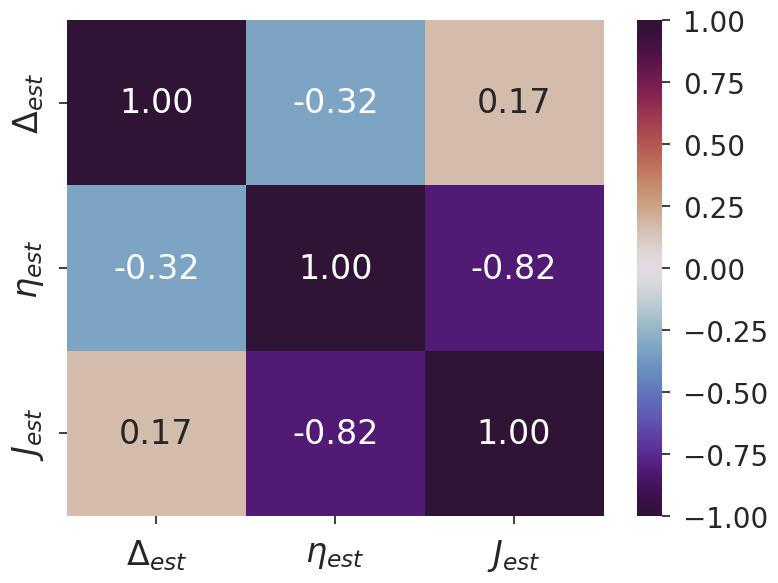

In [64]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsI.svg"), dpi=300)
plt.show()

In [65]:
x_fit= Montbrio_SDEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)
v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

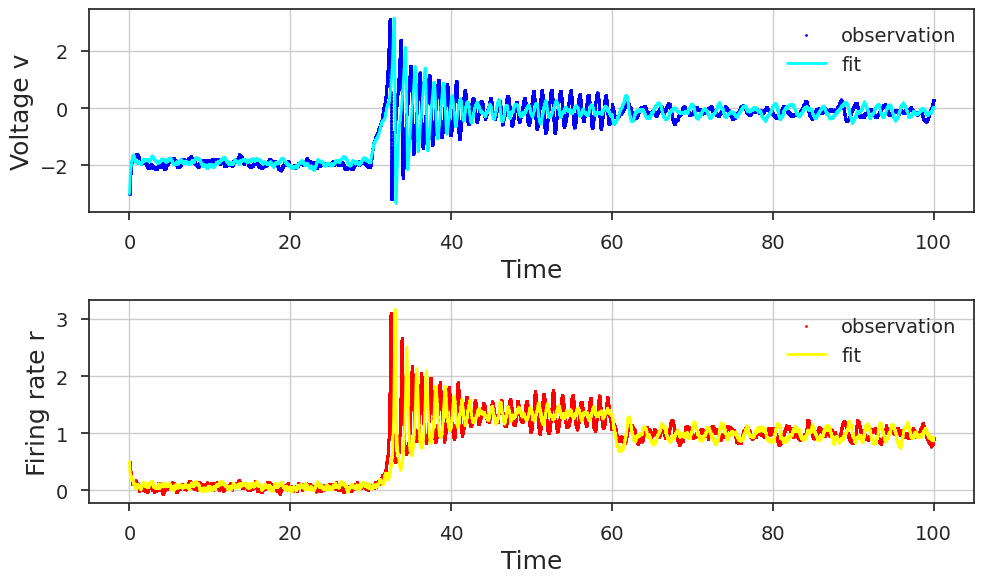

In [66]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observation')
plt.plot(ts, v_fit, lw=2, color='cyan', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='observation')
plt.plot(ts, r_fit, lw=2, color='yellow', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsI.svg"), dpi=300)
plt.show()

In [67]:
alpha_true=eta_true/delta_true
alpha_est=eta_est/delta_est

beta_true=J_true/sqrt(delta_true)
beta_est=J_est/sqrt(delta_est)

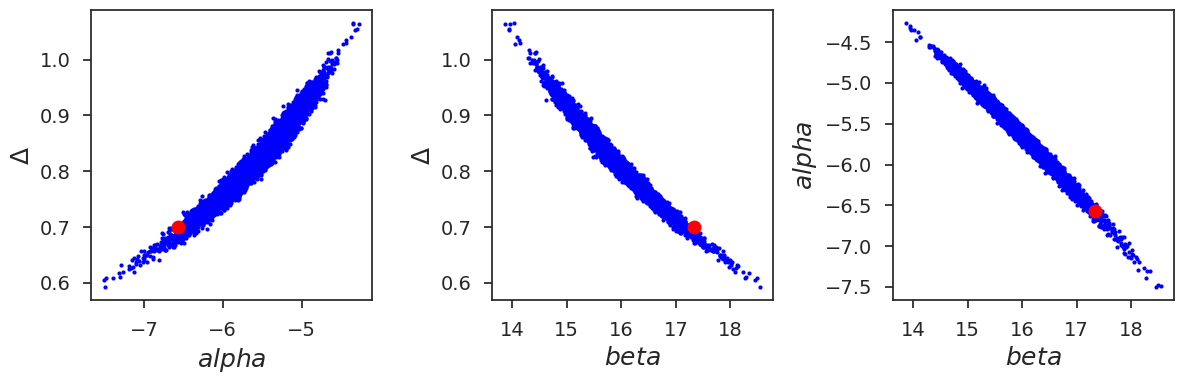

In [68]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(alpha_est, delta_est,'.', color='blue')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(beta_est, delta_est, '.', color='blue')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(beta_est, alpha_est, '.', color='blue')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$alpha$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsI.svg"), dpi=300)
plt.show()

In [69]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([0.0005, 0.0010, 0.0022, 0.0139]) 

Eigenvectors: 
 tensor([[ 0.8805,  0.4670, -0.0668, -0.0462],
        [-0.4355,  0.7935,  0.0934, -0.4146],
        [ 0.1565, -0.3870, -0.0148, -0.9086],
        [ 0.1025, -0.0490,  0.9933,  0.0223]])


In [71]:
sensitivity_vals = pd.Series(1/e_vals, index=params_label)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')
normalized_df=(df-df.min())/(df.max()-df.min())
my_range=list(range(1,len(df.index)+1))


In [72]:
normalized_df

,sensitivity_vals
$\sigma$,0.000000
$J$,0.198979
$\eta$,0.469951
$\Delta$,1.000000


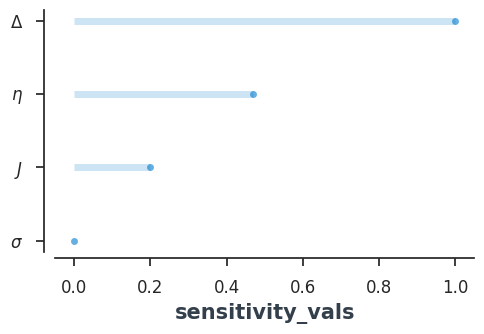

In [73]:

fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=normalized_df, color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(normalized_df, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsI.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsI.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsI.svg"), dpi=300)

plt.show()

In [74]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'true_params_sde_Vfeatures100k_obsI.npy'), true_params)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_sde_Vfeatures100k_obsI.npy'), posterior_samples)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_obs_sde_Vfeatures100k_obsI.npy'), x_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_fit_sde_Vfeatures100k_obsI.npy'), x_fit)

# Load pre simuated data

In [75]:
data_file=np.load('data_input_mpr_sd_sigma=0.1.npz')

In [76]:
keys = data_file.keys()
var_list = list(data_file.keys())
var_list

['nd',
 'nt',
 'ts',
 'dt',
 't0',
 't_final',
 'I0',
 't_on',
 't_off',
 'r_init',
 'v_init',
 'rlim',
 'vlim',
 'vs',
 'rs',
 'delta_true',
 'eta_true',
 'J_true',
 'alpha_true',
 'beta_true',
 'sigma',
 'I_input']

In [77]:
var_inter = ["nt", "dt", "delta_true", "eta_true", "J_true", "sigma"]

for var in var_inter:
    if var in data_file:
        value = data_file[var]
        print(f"{var} = {value}")

nt = 100000
dt = 0.001
delta_true = 0.7
eta_true = -4.6
J_true = 14.5
sigma = 0.1


In [78]:
for var in data_file:
    exec(f"{var} = data_file['{var}']")

In [79]:
vs.shape, rs.shape

((100000,), (100000,))

In [80]:
true_params = np.array([delta_true, eta_true, J_true, sigma])

In [81]:
v_obs=vs
r_obs=rs
x_obs_summary_statistics_v=calculate_summary_statistics(v_obs.reshape(-1), dt, ts, t_on, t_off)
x_obs_summary_statistics_r=calculate_summary_statistics(r_obs.reshape(-1), dt, ts, t_on, t_off)
x_obs_summary_statistics=np.concatenate([x_obs_summary_statistics_v, x_obs_summary_statistics_r]).flatten()

In [82]:
x_obs_summary_statistics.shape

(34,)

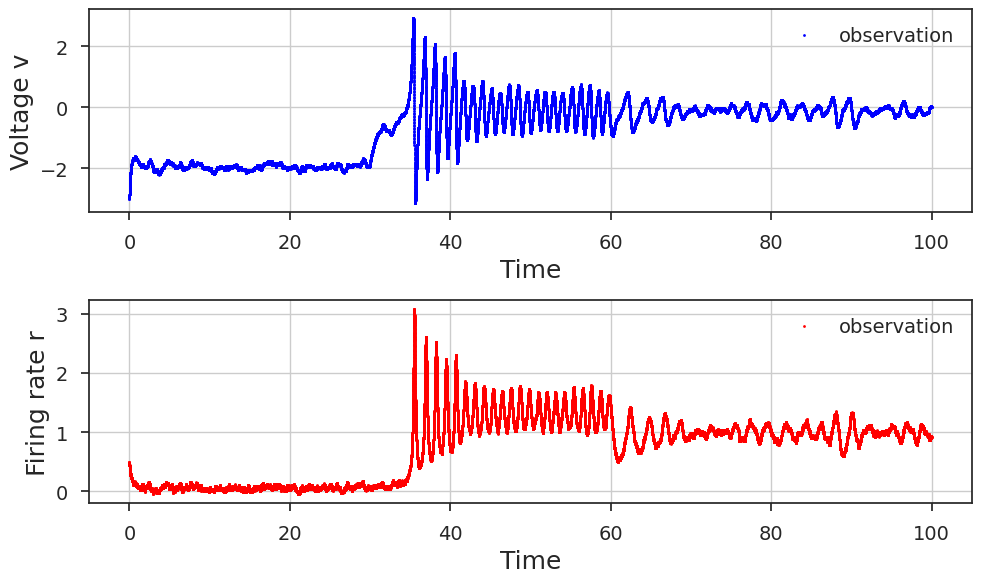

In [83]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='observation')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_obsn.svg"), dpi=300)
plt.show()

### Posterior

In [84]:
num_samples=10000

In [85]:
posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

posterior_samples.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 4)

In [86]:
delta_est=posterior_samples[:,0]
eta_est=posterior_samples[:,1]
J_est=posterior_samples[:,2]
sigma_est=posterior_samples[:,3]

In [87]:
print("delta_est=", delta_est.mean())
print("eta_est=", eta_est.mean())
print("J_est=", J_est.mean())
print("sigma_est=", sigma_est.mean())

delta_est= 0.6596955
eta_est= -4.575112
J_est= 14.442662
sigma_est= 0.107301444


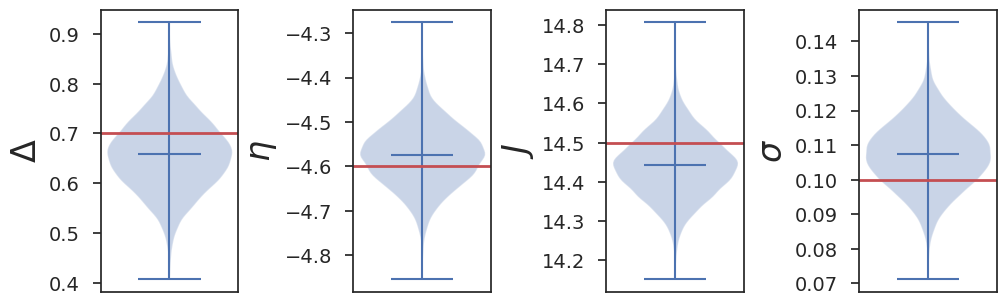

In [88]:
plt.figure(figsize=(10, 3))
for i, variables in enumerate([delta_est, eta_est, J_est, sigma_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel(str(params_label[i]), fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obs.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "PosteriorViloin_Monbtbrio_NMM_sde_EstimatedParams_obsn.svg"), dpi=300)
plt.show()

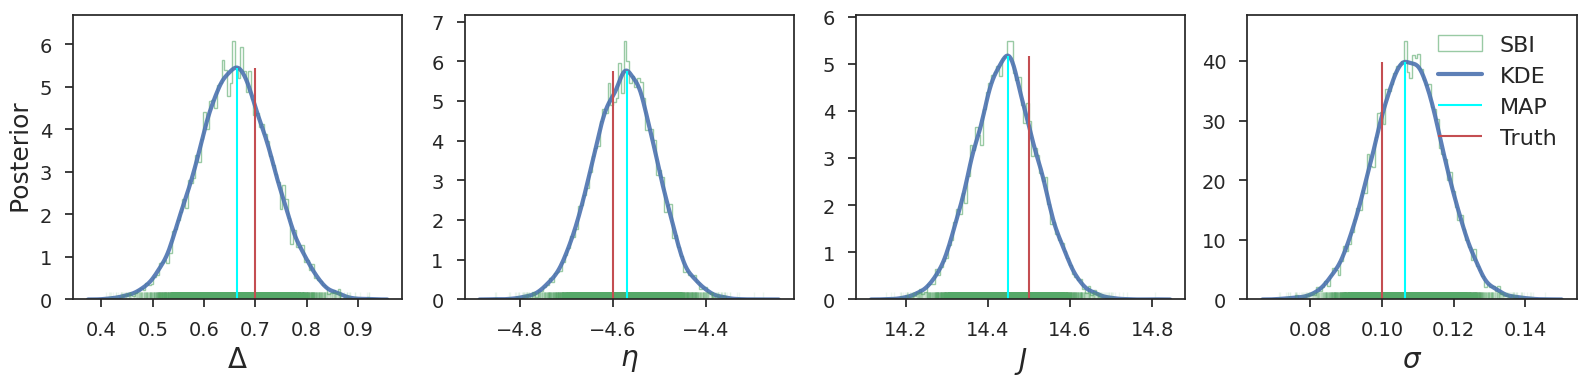

In [89]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 4, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel(str(params_label[i]), fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==3:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Posterior_Monbtbrio_NMM_sde_EstimatedParams_obsn.svg"), dpi=300)

plt.show()

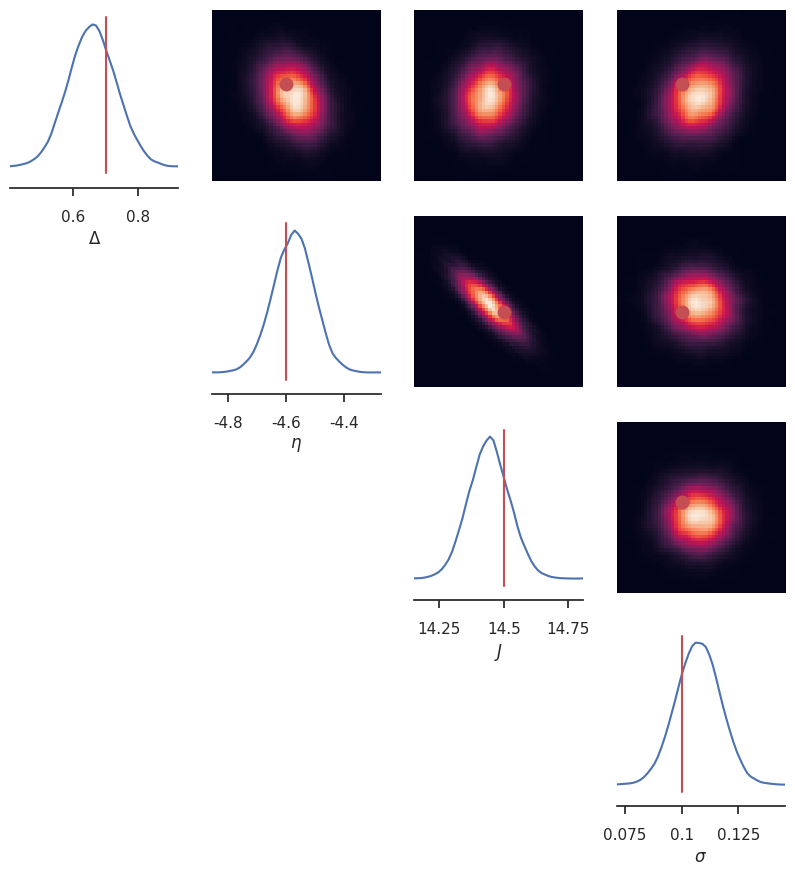

In [90]:
fig, axes = pairplot(posterior_samples,
                           fig_size=(8,8),
                           labels=params_label,
                           upper=['kde'],
                           diag=['kde'],
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');
            
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_pairplot_obsn.svg"), dpi=300)
plt.show()

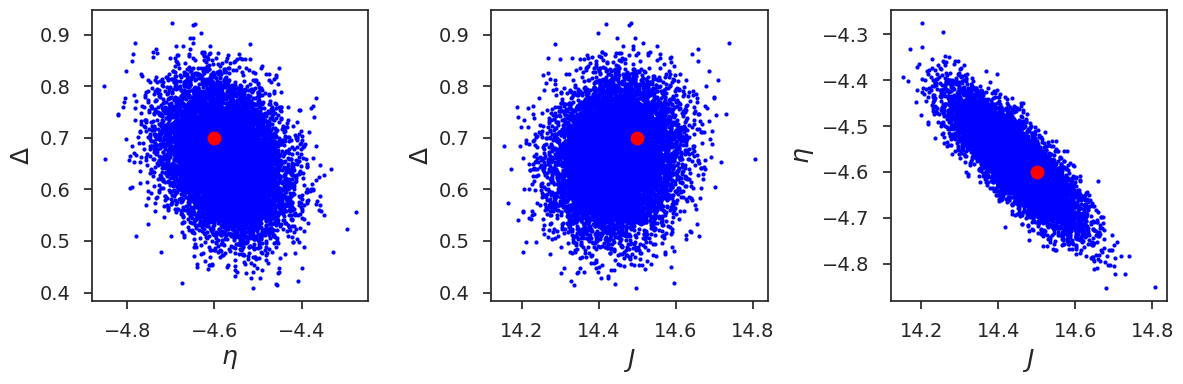

In [91]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(eta_est, delta_est,'.', color='blue')
plt.plot(eta_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$\eta$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(J_est, delta_est, '.',color='blue')
plt.plot(J_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(J_est, eta_est, '.', color='blue')
plt.plot(J_true, eta_true, 'o', color='red', markersize=10)
plt.xlabel("$J$", fontsize=18)
plt.ylabel("$\eta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsJoindist_obsn.svg"), dpi=300)

plt.show()

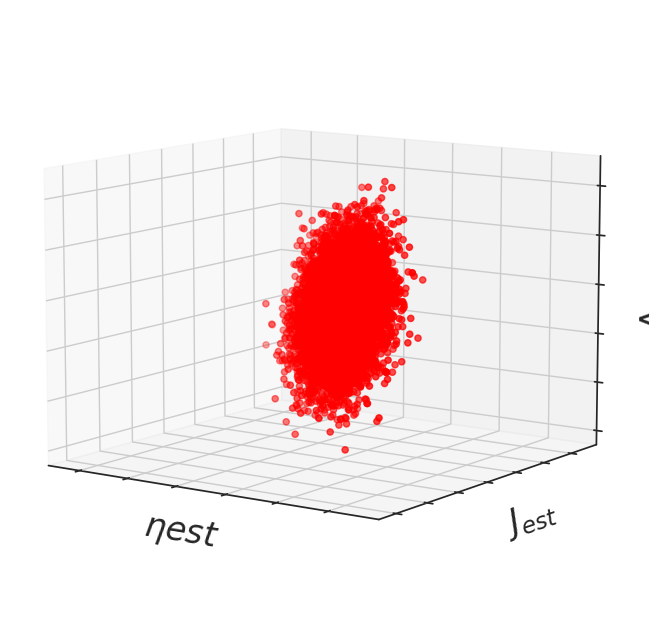

In [92]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x =eta_est
y =J_est
z =delta_est
ax.scatter(x, y, z, c='red', marker='o')
ax.set_xlabel("$\eta{est}$", fontsize=24)
ax.set_ylabel("$J_{est}$", fontsize=24)
ax.set_zlabel("$\Delta_{est}$", fontsize=24)
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(10, 125)
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_Joint3Dpairplot_obsn.svg"), dpi=300)
plt.show()

In [93]:
delta_est=array([delta_est]).T
eta_est=array([eta_est]).T
J_est=array([J_est]).T

In [94]:
params = {'delta_est': delta_est, 'eta_est': eta_est, 'J_est': J_est}
        
f=concatenate((delta_est, eta_est, J_est), axis=1)

df = pd.DataFrame(f, columns=['delta_est',  'eta_est', 'J_est' ])

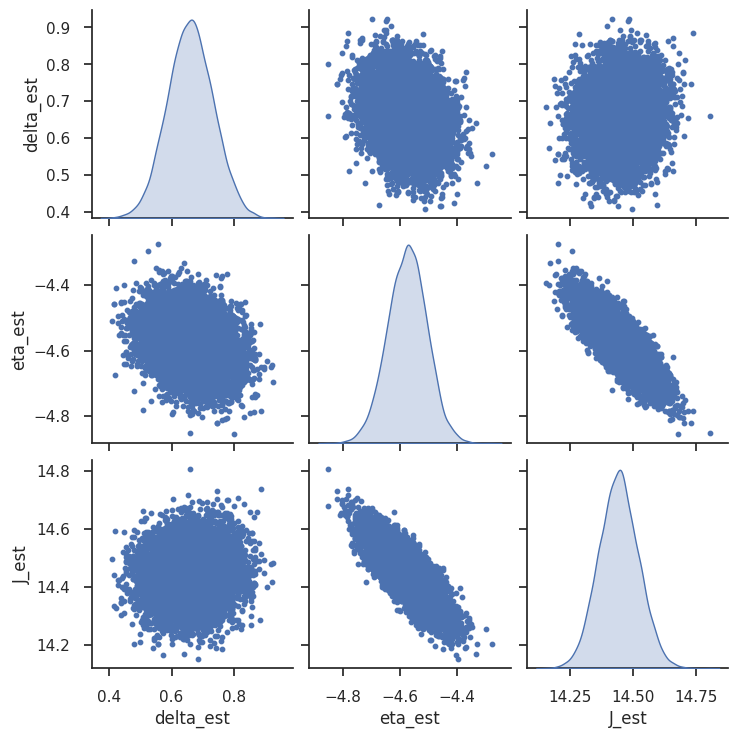

In [95]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, diag_kind="kde", markers="o",plot_kws=dict(s=10, edgecolor="b", linewidth=1))
#g.set(xticklabels=[])
#g.set(yticklabels=[])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_PairParamsScatterdist3d_obsn.svg"), dpi=300)
plt.show()

In [96]:
df.corr()

,delta_est,eta_est,J_est
delta_est,1.000000,-0.274877,0.108082
eta_est,-0.274877,1.000000,-0.819018
J_est,0.108082,-0.819018,1.000000


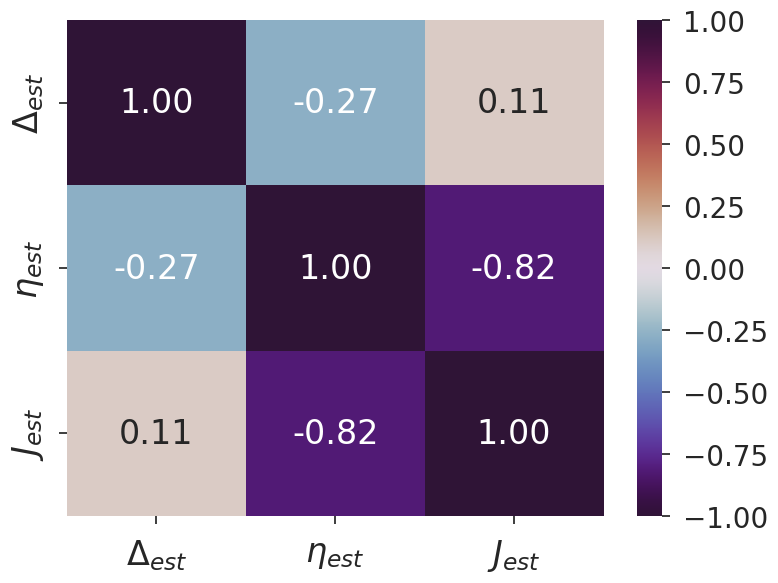

In [97]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, robust=True, cmap='twilight_shifted', linewidths=.0, annot_kws={'size':24}, fmt=".2f", vmin=-1, vmax=1, ax=ax, xticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ], yticklabels=['$\Delta_{est}$', '$\eta_{est}$', '$J_{est}$' ])
#ax.set_xticklabels()
#ax.set_yticklabels()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax.tick_params(labelsize=24)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_posterior_CorrParams_obsn.svg"), dpi=300)
plt.show()

In [98]:
x_fit= Montbrio_SDEmodel_numba(np.percentile(posterior_samples, [50], axis=0).reshape(-1), constants, I_input, dt, ts)

v_fit=x_fit[0:nt]
r_fit=x_fit[nt:2*nt]

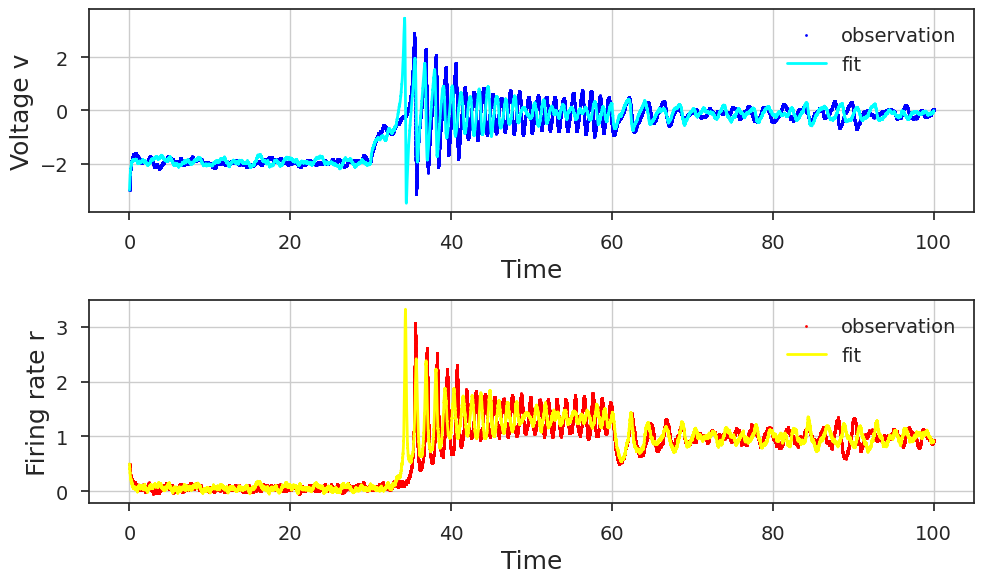

In [99]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.', markersize=4, color='blue', label='observation')
plt.plot(ts, v_fit, lw=2, color='cyan', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs,  '.', markersize=4, color='red',label='observation')
plt.plot(ts, r_fit, lw=2, color='yellow', label='fit')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_fit_obsn.svg"), dpi=300)
plt.show()

In [100]:
alpha_true=eta_true/delta_true
alpha_est=eta_est/delta_est

beta_true=J_true/sqrt(delta_true)
beta_est=J_est/sqrt(delta_est)

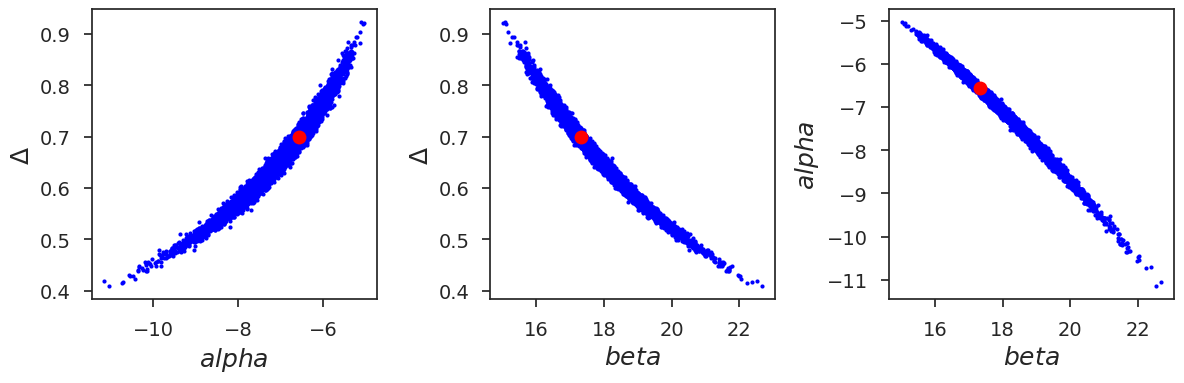

In [101]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(alpha_est, delta_est,'.', color='blue')
plt.plot(alpha_true, delta_true,'o', color='red', markersize=10)
plt.xlabel("$alpha$", fontsize=18)
plt.ylabel("$\Delta$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(132)
plt.plot(beta_est, delta_est, '.', color='blue')
plt.plot(beta_true, delta_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$\Delta$",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(133)
plt.plot(beta_est, alpha_est, '.', color='blue')
plt.plot(beta_true, alpha_true, 'o', color='red', markersize=10)
plt.xlabel("$beta$", fontsize=18)
plt.ylabel("$alpha$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "Monbtbrio_NMM_sde_ratios_obsn.svg"), dpi=300)
plt.show()

In [102]:
sensitivity = ActiveSubspace(posterior.set_default_x(x_obs_summary_statistics))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [103]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([0.0003, 0.0008, 0.0009, 0.0123]) 

Eigenvectors: 
 tensor([[ 0.9494,  0.2886, -0.1138,  0.0482],
        [-0.2503,  0.8379,  0.2200,  0.4324],
        [ 0.0687, -0.4170, -0.1033,  0.9004],
        [ 0.1767, -0.2019,  0.9633,  0.0035]])


In [104]:
sensitivity_vals = pd.Series(1/e_vals, index=params_label)

df = pd.DataFrame({'sensitivity_vals' : sensitivity_vals})
df = df.sort_values(by='sensitivity_vals')
normalized_df=(df-df.min())/(df.max()-df.min())
my_range=list(range(1,len(df.index)+1))


In [105]:
df

,sensitivity_vals
$\sigma$,80.995895
$J$,1073.519775
$\eta$,1261.893677
$\Delta$,2922.574707


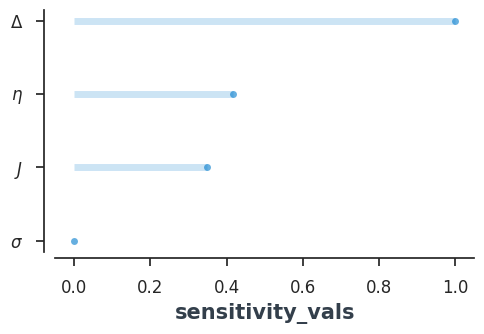

In [106]:

fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=normalized_df, color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(normalized_df, my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

plt.yticks(my_range, df.index)

ax.set_xlabel('sensitivity_vals', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_xlim(0,200)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.tight_layout()

plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsn.png"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsn.eps"), dpi=300)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir), "sensitivity_vals_obsn.svg"), dpi=300)

plt.show()

In [107]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'true_params_sde_Vfeatures100k_obsn.npy'), true_params)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'posterior_samples_sde_Vfeatures100k_obsn.npy'), posterior_samples)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_obs_sde_Vfeatures100k_obsn.npy'), x_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'x_fit_sde_Vfeatures100k_obsn.npy'), x_fit)